In [89]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.random import seed
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
from sklearn.model_selection import TimeSeriesSplit

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [90]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

seed(10)
tf.random.set_seed(10)

In [91]:
df=pd.read_csv("asystom_sign_prep2.csv", sep=";")
df

,time,s_00,s_01,s_02,s_03,s_04,s_05,s_06,s_07,s_08,...,vib_y_root,vib_y_vel,vib_z_acc,vib_z_f1,vib_z_f2,vib_z_f3,vib_z_kurt,vib_z_peak,vib_z_root,vib_z_vel
0,03/01/2023 16:32,-65.550469,-69.176013,-68.056764,-71.181048,-68.667887,-70.924697,-73.305104,-69.514763,-72.284276,...,0.000000,0.096132,0.013672,0.000000,0.000000,0.000000,2.754253,0.049561,0.000000,0.146487
1,03/01/2023 15:47,-64.206912,-68.020142,-67.466239,-70.629435,-69.173724,-71.734951,-72.101167,-70.629435,-72.483406,...,0.000000,0.088502,0.014649,0.000000,0.000000,0.000000,2.830549,0.052247,0.000000,0.216678
2,03/01/2023 15:02,-64.923323,-68.928817,-68.015564,-71.359579,-68.310826,-71.258869,-72.520027,-71.046006,-72.856489,...,0.000000,0.106813,0.013916,0.000000,0.000000,0.000000,2.876326,0.050782,0.000000,0.183108
3,03/01/2023 14:17,-64.220645,-68.271916,-68.594644,-71.309224,-67.287709,-71.222248,-72.265965,-70.384527,-73.479057,...,0.000000,0.115969,0.014160,0.000000,0.000000,0.000000,2.888533,0.057618,0.000000,0.207523
4,03/01/2023 13:32,-63.804074,-67.997253,-67.706569,-70.368505,-68.725109,-71.874571,-72.206455,-71.368734,-72.256809,...,0.000000,0.119020,0.013916,0.000000,0.000000,0.000000,2.981613,0.048096,0.000000,0.247196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3369,01/10/2022 02:08,-64.314488,-61.382467,-58.736553,-51.029984,-49.480430,-45.854887,-46.230259,-40.837720,-41.851682,...,1646.143282,0.134279,0.241215,0.093080,0.012207,0.010681,3.140307,0.946548,1697.413596,0.268559
3370,01/10/2022 01:38,-62.710002,-60.819409,-60.494392,-50.975051,-48.468757,-43.799496,-44.545663,-41.233692,-44.179446,...,1336.690318,0.149538,0.234379,0.067140,0.013733,0.024414,3.068589,0.886732,1671.320668,0.250248
3371,01/10/2022 01:08,-63.817807,-60.702678,-58.596933,-49.981689,-48.894484,-45.550469,-45.385672,-41.499199,-43.426413,...,1290.455482,0.189212,0.231449,0.137331,0.006104,0.010681,3.071641,0.887221,1727.168688,0.280766
3372,01/10/2022 00:38,-62.680247,-61.993591,-56.944381,-50.959030,-48.663310,-44.486152,-44.852369,-41.556420,-43.488212,...,1680.476081,0.126650,0.231449,0.122072,0.010681,0.012207,2.940414,0.815198,1707.026780,0.253300


In [92]:
df = df.sort_values(by='time',ascending=True)

df.head()
df =df.set_index('time')
df.index =pd.to_datetime(df.index)

In [93]:
tss = TimeSeriesSplit(n_splits=5)
df = df.sort_index()
df

,s_00,s_01,s_02,s_03,s_04,s_05,s_06,s_07,s_08,s_09,...,vib_y_root,vib_y_vel,vib_z_acc,vib_z_f1,vib_z_f2,vib_z_f3,vib_z_kurt,vib_z_peak,vib_z_root,vib_z_vel
time,,,,,,,,,,,,,,,,,,,,,
2022-01-10 00:08:00,-62.545205,-61.263447,-58.221561,-51.155871,-46.894026,-46.266880,-46.159304,-40.668345,-43.497368,-42.027924,...,1299.153124,0.109865,0.233402,0.044251,0.016785,0.018311,2.876326,0.829114,1278.095674,0.256352
2022-01-10 00:38:00,-62.680247,-61.993591,-56.944381,-50.959030,-48.663310,-44.486152,-44.852369,-41.556420,-43.488212,-42.469673,...,1680.476081,0.126650,0.231449,0.122072,0.010681,0.012207,2.940414,0.815198,1707.026780,0.253300
2022-01-10 01:08:00,-63.817807,-60.702678,-58.596933,-49.981689,-48.894484,-45.550469,-45.385672,-41.499199,-43.426413,-42.016480,...,1290.455482,0.189212,0.231449,0.137331,0.006104,0.010681,3.071641,0.887221,1727.168688,0.280766
2022-01-10 01:38:00,-62.710002,-60.819409,-60.494392,-50.975051,-48.468757,-43.799496,-44.545663,-41.233692,-44.179446,-41.668574,...,1336.690318,0.149538,0.234379,0.067140,0.013733,0.024414,3.068589,0.886732,1671.320668,0.250248
2022-01-10 02:08:00,-64.314488,-61.382467,-58.736553,-51.029984,-49.480430,-45.854887,-46.230259,-40.837720,-41.851682,-42.094301,...,1646.143282,0.134279,0.241215,0.093080,0.012207,0.010681,3.140307,0.946548,1697.413596,0.268559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-01 13:32:00,-63.804074,-67.997253,-67.706569,-70.368505,-68.725109,-71.874571,-72.206455,-71.368734,-72.256809,-75.536736,...,0.000000,0.119020,0.013916,0.000000,0.000000,0.000000,2.981613,0.048096,0.000000,0.247196
2023-03-01 14:17:00,-64.220645,-68.271916,-68.594644,-71.309224,-67.287709,-71.222248,-72.265965,-70.384527,-73.479057,-75.529870,...,0.000000,0.115969,0.014160,0.000000,0.000000,0.000000,2.888533,0.057618,0.000000,0.207523
2023-03-01 15:02:00,-64.923323,-68.928817,-68.015564,-71.359579,-68.310826,-71.258869,-72.520027,-71.046006,-72.856489,-75.431449,...,0.000000,0.106813,0.013916,0.000000,0.000000,0.000000,2.876326,0.050782,0.000000,0.183108


In [94]:
train = df.loc[df.index < '2022-10-22']
test = df.loc[df.index >= '2022-10-22']

print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (1509, 47)
Test dataset shape: (1865, 47)


In [95]:
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)

In [96]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [97]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (1509, 1, 47)
Test data shape: (1865, 1, 47)


In [98]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True,
    kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

In [99]:
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 47)]           0         
                                                                 
 lstm_8 (LSTM)               (None, 1, 16)             4096      
                                                                 
 lstm_9 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector_2 (RepeatVect  (None, 1, 4)             0         
 or)                                                             
                                                                 
 lstm_10 (LSTM)              (None, 1, 4)              144       
                                                                 
 lstm_11 (LSTM)              (None, 1, 16)             1344      
                                                           

In [100]:
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,validation_split=0.05).history

Epoch 1/100
144/144 [==============================] - 7s 11ms/step - loss: 0.4713 - val_loss: 0.3331
Epoch 2/100
144/144 [==============================] - 1s 5ms/step - loss: 0.1347 - val_loss: 0.0774
Epoch 3/100
144/144 [==============================] - 1s 5ms/step - loss: 0.0998 - val_loss: 0.0797
Epoch 4/100
144/144 [==============================] - 1s 5ms/step - loss: 0.0970 - val_loss: 0.0751
Epoch 5/100
144/144 [==============================] - 1s 5ms/step - loss: 0.0940 - val_loss: 0.0781
Epoch 6/100
144/144 [==============================] - 1s 5ms/step - loss: 0.0916 - val_loss: 0.0720
Epoch 7/100
144/144 [==============================] - 1s 5ms/step - loss: 0.0897 - val_loss: 0.0760
Epoch 8/100
144/144 [==============================] - 1s 6ms/step - loss: 0.0887 - val_loss: 0.0767
Epoch 9/100
144/144 [==============================] - 1s 5ms/step - loss: 0.0882 - val_loss: 0.0767
Epoch 10/100
144/144 [==============================] - 1s 6ms/step - loss: 0.0878 - val_l

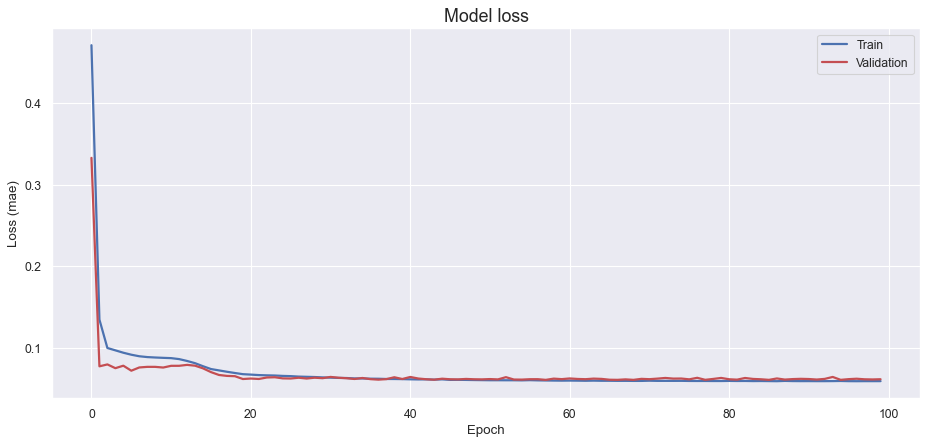

In [101]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

48/48 [==============================] - 1s 3ms/step


C:\Users\fondr\AppData\Local\Temp\ipykernel_2200\3806888063.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue')


<AxesSubplot:title={'center':'Loss Distribution'}, xlabel='Loss_mae', ylabel='Density'>

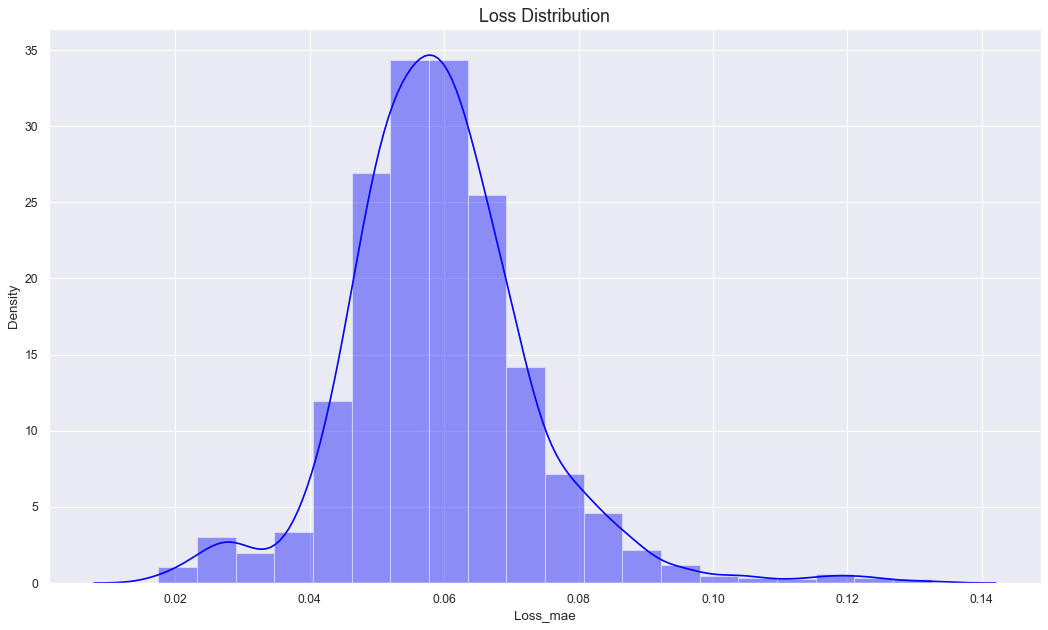

In [102]:
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index
scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue')

In [106]:
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index
scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.14
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

59/59 [==============================] - 0s 3ms/step


,Loss_mae,Threshold,Anomaly
time,,,
2022-10-22 00:02:00,0.049767,0.14,False
2022-10-22 00:32:00,0.061362,0.14,False
2022-10-22 01:02:00,0.050760,0.14,False
2022-10-22 01:32:00,0.059717,0.14,False
2022-10-22 02:02:00,0.070423,0.14,False


In [107]:
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index
scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.14
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

48/48 [==============================] - 0s 3ms/step


<AxesSubplot:xlabel='time'>

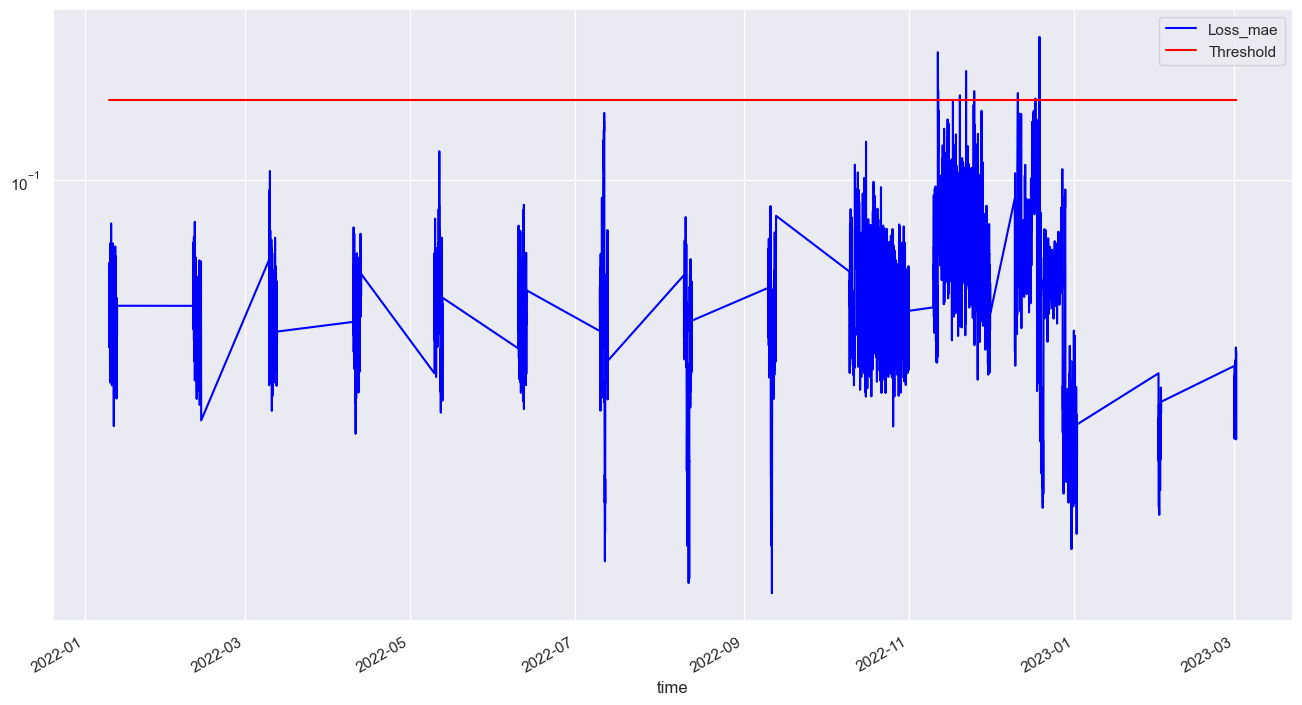

In [108]:
scored.plot(logy=True, figsize=(16,9), color=['blue','red'])

In [110]:
model.save("model.h5")
print("Model saved")

Model saved
